In [1]:
import pandas as pd
import numpy as np

#Models
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# pip install xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score , confusion_matrix, classification_report


# hyperparameter optimization
# pip install optuna
import optuna

#Visualizations 
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#pip install sort-dataframeby-monthorweek
#pip install sorted-months-weekdays
import sort_dataframeby_monthorweek as sd

#My utils
from utils.preprocess import preprocess_data
from utils.encoding import encode_categorical


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data\hotel_bookings.csv')

1. numerical_features
2. ordinalcolumn
3. categorical_features
4. Data Leakage: reservation_status is similar values to the target variable
5. Data Leakage: reservation_status_date > Date at which the last status was set


Main features:

* is_canceled - Booking cancel or not => The Target V
* hotel - 2 Types (City/Resort) V
* lead_time - V   > Seniority days from booking to check-in date
* total_of_special_requests - V > amount of requests in during booking
* booking_changes - V > amount of changes during booking 
* previous_cancellations - V > amount of prev cancellations
* is_repeated_guest - V > New / return guest
* adults / babies / children  - V > family
* days_in_waiting_list - V  > Number of days the booking was in the waiting list before it was confirmed to the customer. (unconfirmed bookings period)
* arrival_date_year / arrival_date_week_number / arrival_date_day_of_month - V > Arrival (not date)
* stays_in_weekend_nights / stays_in_week_nights - V > number of stay nights
* deposit_type - V > Indication on if the customer made a deposit to guarantee the booking
* market_segment - V > Market segment designation 
* distribution_channel - V > Booking distribution channel
* customer_type - V > Type of booking (Contract , Group, transient = individual )
* Country - V



Abnormal findings:

Total nights can't be zero = 

len(df[(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] == 0)]) => we have 715 rows => So we will remove such rows

Total family can't be zero = 

df[df['adults']+df['babies']+df['children'] == 0]  > we have 180 rows . So we will remove such rows

Missing Values:
* round(columns_with_missing_values/len(df),10) 
* children - 0.0034% - we will impute by mode
* country - 0.4% - we will impute by mode
* Agent - 13.6% - we will impute by mode
* company - 94% - we will remove such feature


duplicates:
* fully_duplicated_rows = df.duplicated(keep=False) => we have 40165 rows. So we will remove such rows

In [12]:

columns_of_interest = ['is_canceled', 'hotel', 'total_of_special_requests', 'booking_changes',
                       'previous_cancellations', 'is_repeated_guest', 'arrival_date_year', 'deposit_type', 'market_segment',
                        'distribution_channel', 'customer_type']

for column in columns_of_interest:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'is_canceled': [0 1]
Unique values in 'hotel': ['Resort Hotel' 'City Hotel']
Unique values in 'total_of_special_requests': [0 1 3 2 4 5]
Unique values in 'booking_changes': [ 3  4  0  1  2  5 17  6  8  7 10 16  9 13 12 20 14 15 11 21 18]
Unique values in 'previous_cancellations': [ 0  1  2  3 26 25 14  4 24 19  5 21  6 13 11]
Unique values in 'is_repeated_guest': [0 1]
Unique values in 'arrival_date_year': [2015 2016 2017]
Unique values in 'deposit_type': ['No Deposit' 'Refundable' 'Non Refund']
Unique values in 'market_segment': ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
Unique values in 'distribution_channel': ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
Unique values in 'customer_type': ['Transient' 'Contract' 'Transient-Party' 'Group']


In [5]:
# Check the number of rows and columns in the data
df.shape

(119390, 32)

In [9]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
#Categorical
data_types = df.dtypes
categorical_features = data_types[data_types == 'object'].index.tolist()
categorical_features

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [4]:
#Numerical
numerical_features = data_types[(data_types == 'int64') | (data_types == 'float64')].index.tolist()
numerical_features

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [5]:
ordinalcolumn =  ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status_date']
ordinalcolumn

['arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'reservation_status_date']

In [16]:
#Missing values
missing_values_count = df.isnull().sum()
columns_with_missing_values = missing_values_count[missing_values_count > 0]
round(columns_with_missing_values/len(df),10)

children    0.000034
country     0.004087
agent       0.136862
company     0.943069
dtype: float64

In [19]:
#duplicate rows
fully_duplicated_rows = df.duplicated(keep=False)
df[fully_duplicated_rows].shape

(40165, 32)

In [7]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [18]:
df.loc[df.index.isin([4,5])]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [20]:
# There are some rows with total number of adults, children or babies equal to zero. So we will remove such rows.
df[df['adults']+df['babies']+df['children'] == 0].shape

(180, 32)

In [25]:
len(df[(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] == 0)])

715

715 bookings don't have both weekday or weekend nights which potentialy an error in the data as this is not possible in real life.

Therefore these rows can be eliminated from the dataset.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [103]:
df["is_canceled"].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [ ]:
df.describe().T

## EDA

#### is_canceled

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64


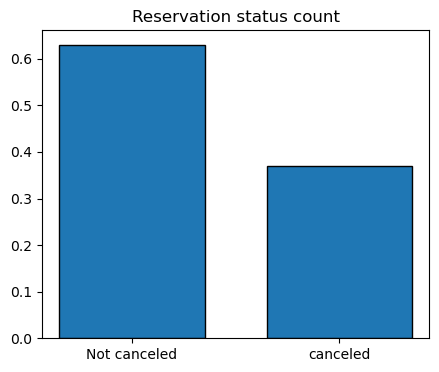

In [25]:
cancelled_perc = df['is_canceled'].value_counts(normalize = True)
print(cancelled_perc)

plt.figure(figsize = (5,4))
plt.title('Reservation status count')
plt.bar(['Not canceled','canceled'],df['is_canceled'].value_counts(normalize = True), edgecolor = 'k',width = 0.7)
plt.show()

From total data we have 37% cancelations. 

#### hotel booking & status booking

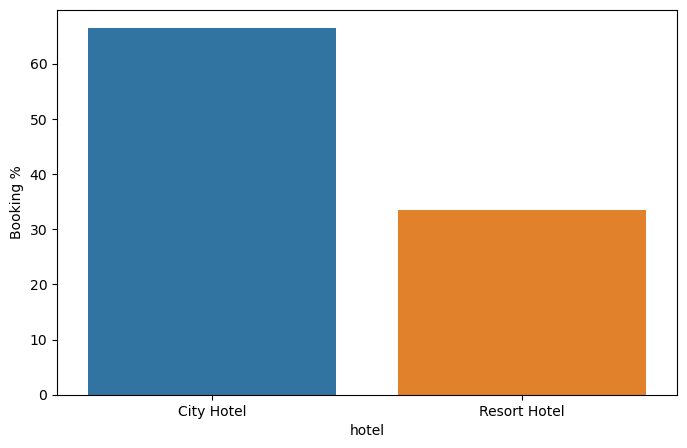

In [60]:
grouped_by_hotel = df.groupby('hotel')
d1 = pd.DataFrame((grouped_by_hotel.size()/df.shape[0])*100).reset_index().rename(columns = {0:'Booking %'})      #Calculating percentage
plt.figure(figsize = (8,5))
sns.barplot(x = d1['hotel'], y = d1['Booking %'] )
plt.show()

Around 60% bookings are for City hotel and 40% bookings are for Resort hotel.

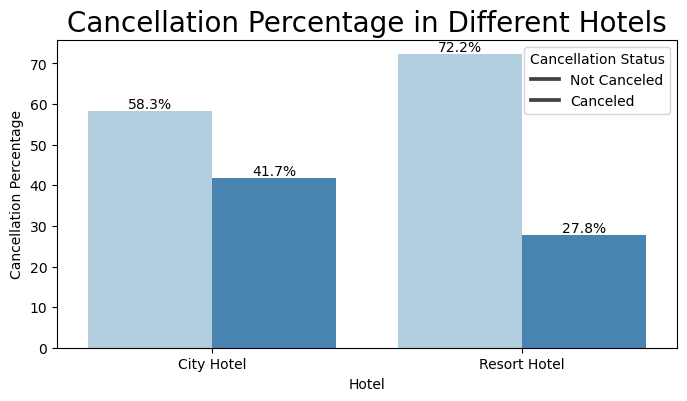

In [27]:
# Calculate cancellation percentages for each hotel
cancellation_percentages = df.groupby(['hotel', 'is_canceled']).size() / df.groupby('hotel').size() * 100
cancellation_percentages = cancellation_percentages.reset_index(name='Percentage')

# Plot the bar chart with percentages
plt.figure(figsize=(8, 4))
ax1 = sns.barplot(x='hotel', y='Percentage', hue='is_canceled', data=cancellation_percentages, palette='Blues')

# Annotate the bars with percentages
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.title('Cancellation Percentage in Different Hotels', size=20)
plt.xlabel('Hotel')
plt.ylabel('Cancellation Percentage')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

Cancellations in resort hotel=  27.8%

Cancellations in city hotel=  41.58%

#### Correlations

In [23]:
correlation = df.corr()['is_canceled']
correlation_sorted_abs = correlation.abs().sort_values(ascending=False)
correlation_sorted = correlation.loc[correlation_sorted_abs.index]
correlation_sorted

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
booking_changes                  -0.144381
previous_cancellations            0.110133
is_repeated_guest                -0.084793
agent                            -0.083114
adults                            0.060017
previous_bookings_not_canceled   -0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                           -0.032491
stays_in_week_nights              0.024765
company                          -0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month        -0.006130
children                          0.005048
stays_in_weekend_nights          -0.001791
Name: is_canceled, dtype: float64

highest positive correlations : lead_time followed by previous_cancellations

highest negative correlations : total_of_special_requests, required_car_parking_spaces

#### Family

In [27]:
((len(df.loc[(df['children'] != 0) | (df['babies'] != 0)]))/(len(df))) * 100

7.819750397855767

The number of customers having children or babies or both are only 8.00% .

Therefore this information is not significant in deciding whether to cancel the booking or not.

#### is_repeated_guest vs is_canceled

Cancelations among new guests = 37.79%
Cancelations among old guests = 14.49%


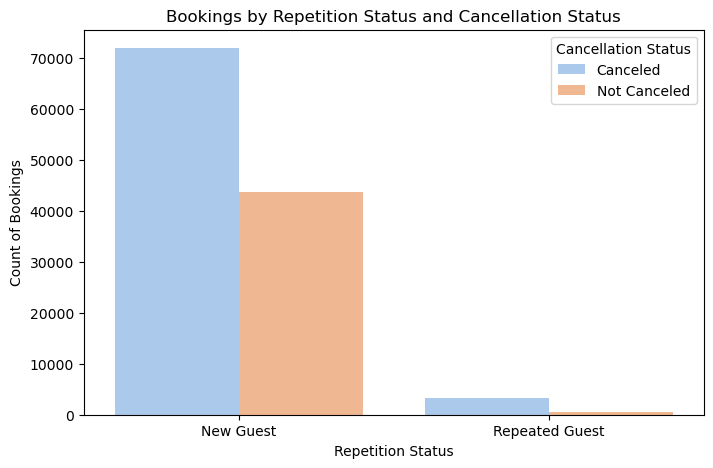

In [30]:
cancelations_among_new_guest = len(df[(df['is_repeated_guest'] == 0) & (df['is_canceled'] == 1)]) / len(df[df['is_repeated_guest'] == 0])
cancelations_among_old_guest = len(df[(df['is_repeated_guest'] == 1) & (df['is_canceled'] == 1)]) / len(df[df['is_repeated_guest'] == 1])

print('Cancelations among new guests = {:.2%}'.format(cancelations_among_new_guest))
print('Cancelations among old guests = {:.2%}'.format(cancelations_among_old_guest))

# Data Visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_repeated_guest', hue='is_canceled', palette='pastel')
plt.xlabel('Repetition Status')
plt.ylabel('Count of Bookings')
plt.title('Bookings by Repetition Status and Cancellation Status')
plt.legend(title='Cancellation Status', labels=['Canceled', 'Not Canceled'])
plt.xticks([0, 1], ['New Guest', 'Repeated Guest'])
plt.show()

As seen in the correlation table, the above graph is the evidence that maximum customers are new comers and they are less likely to cancel their current booking.

Old guests are less likely to cancel the booking (14%).

#### previous_cancellations vs is_canceled

In [4]:
# previous_cancellations vs calculate cancellation 
cancellation_stats = df.groupby('previous_cancellations')['is_canceled'].mean()
booking_counts = df['previous_cancellations'].value_counts()
cancellation_count = df.groupby('previous_cancellations')['is_canceled'].sum()

# Combine the cancellation statistics and booking counts into a new DataFrame
result_df = pd.concat([booking_counts, cancellation_count, cancellation_stats], axis=1)
result_df.columns = ['Booking_Count', 'Cancellation_Count', 'Cancellation_Percentage']

result_df

,Booking_Count,Cancellation_Count,Cancellation_Percentage
0,112906,38282,0.339061
1,6051,5714,0.944307
2,116,38,0.327586
3,65,20,0.307692
24,48,48,1.000000
11,35,10,0.285714
4,31,7,0.225806
26,26,26,1.000000
25,25,25,1.000000
6,22,7,0.318182


Maximum customers have 0 previous cancellations. They are less likely to cancel the current booking.

However, customers who have cancelled once earlier are more likely to cancel the current booking.
 
This also matches with the positive correlation between previous_cancellations and is_cancelled.

#### reserved_room_type vs is_canceled

In [36]:
#reserved_room_type vs assigned_room_type
my_small_df = df.loc[df['reserved_room_type'] != df['assigned_room_type']]
my_small_df['is_canceled'].value_counts(normalize=True) * 100

0    94.623584
1     5.376416
Name: is_canceled, dtype: float64

There are only 5% cancellations in such a case.

#### booking_changes va is_canceled

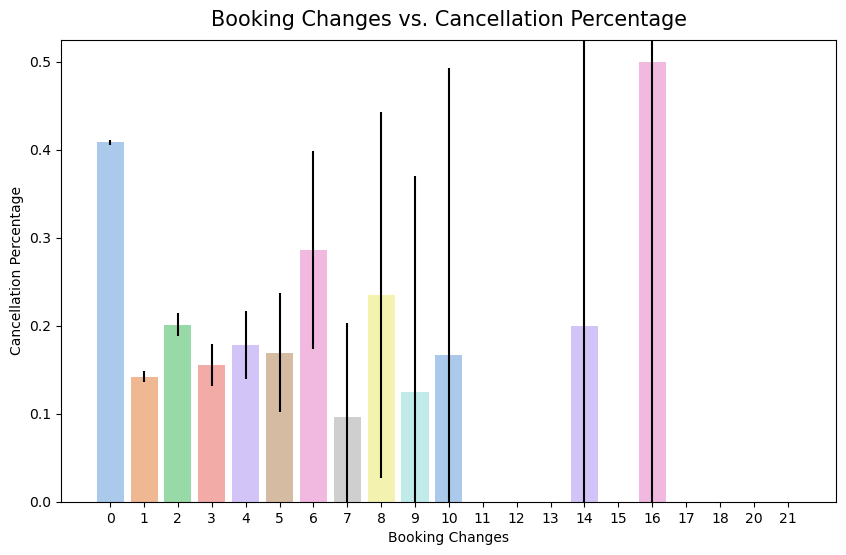

In [37]:
# Calculate cancellation percentage for each category of 'booking_changes'
cancellation_percentage = df.groupby('booking_changes')['is_canceled'].mean()

# Data Visualization - Bar plot with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_percentage.index, y=cancellation_percentage.values, palette='pastel')
plt.xlabel('Booking Changes')
plt.ylabel('Cancellation Percentage')
plt.title('Booking Changes vs. Cancellation Percentage', fontsize=15, pad=10)

# Adding error bars (confidence interval)
error_bar_values = df.groupby('booking_changes')['is_canceled'].sem() * 1.96  # Assuming 95% confidence interval
plt.errorbar(x=cancellation_percentage.index, y=cancellation_percentage.values, yerr=error_bar_values, fmt='none', color='black')

plt.show()

In [42]:
cancellation_percentage.sort_values(ascending=False).head(10)

booking_changes
16    0.500000
0     0.408542
6     0.285714
8     0.235294
2     0.201314
14    0.200000
4     0.178191
5     0.169492
10    0.166667
3     0.155340
Name: is_canceled, dtype: float64

no trend in it's impact on the cancellation of bookings.

#### deposit_type vs is_canceled

In [56]:
#deposit_type vs is_canceled
# Calculate cancellation count and percentage for each deposit type
cancellation_count = df.groupby('deposit_type')['is_canceled'].sum()
cancellation_percentage = df.groupby('deposit_type')['is_canceled'].mean() * 100

# Create DataFrame 'df_tem' with cancellation_count and cancellation_percentage columns
df_tem = pd.concat([cancellation_count, cancellation_percentage], axis=1)
df_tem.columns = ['cancellation_count', 'cancellation_percentage']

df_tem

,cancellation_count,cancellation_percentage
deposit_type,,
No Deposit,29694,28.377022
Non Refund,14494,99.362446
Refundable,36,22.222222


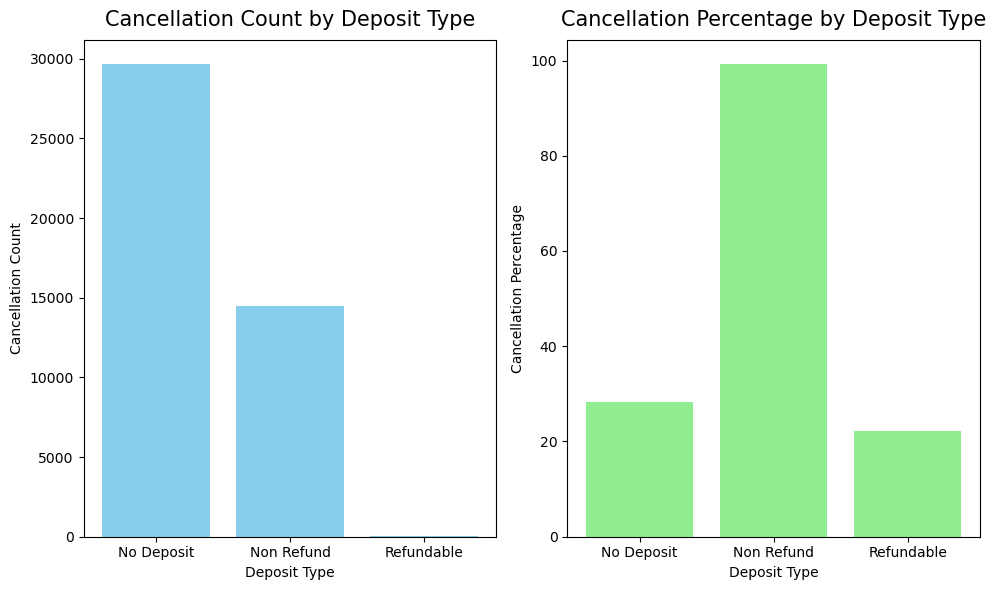

In [57]:
# Data Visualization - Side by side bar plots
plt.figure(figsize=(10, 6))

# Bar plot for cancellation count
plt.subplot(1, 2, 1)
plt.bar(df_tem.index, df_tem['cancellation_count'], color='skyblue')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Count')
plt.title('Cancellation Count by Deposit Type', fontsize=15, pad=10)

# Bar plot for cancellation percentage
plt.subplot(1, 2, 2)
plt.bar(df_tem.index, df_tem['cancellation_percentage'], color='lightgreen')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Percentage')
plt.title('Cancellation Percentage by Deposit Type', fontsize=15, pad=10)

plt.tight_layout()
plt.show()

 bookings that are non_refundable are canceled.

#### days_in_waiting_list vs is_canceled

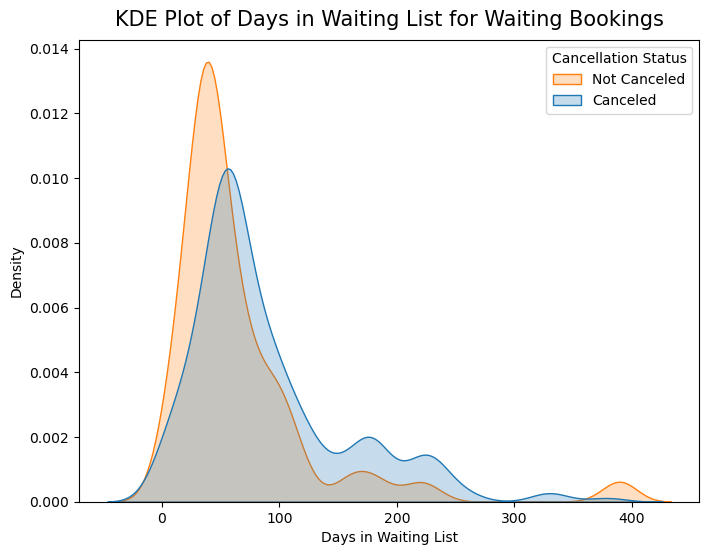

In [8]:
# days_in_waiting_list vs cancellation 
waiting_bookings = df[df['days_in_waiting_list'] !=0]
plt.figure(figsize=(8, 6))
sns.kdeplot(data=waiting_bookings, x='days_in_waiting_list', hue='is_canceled', fill=True, common_norm=False)
plt.xlabel('Days in Waiting List')
plt.ylabel('Density')
plt.title('KDE Plot of Days in Waiting List for Waiting Bookings', fontsize=15, pad=10)
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

most of the bookings that are cancelled have waiting period of less 150 days.

Also most of bookings that are not cancelled also have waiting period less than 150 days.

Therefore  this shows that waiting period has no effect on cancellation of bookings.

#### arrival_date_year vs is_canceled

2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64


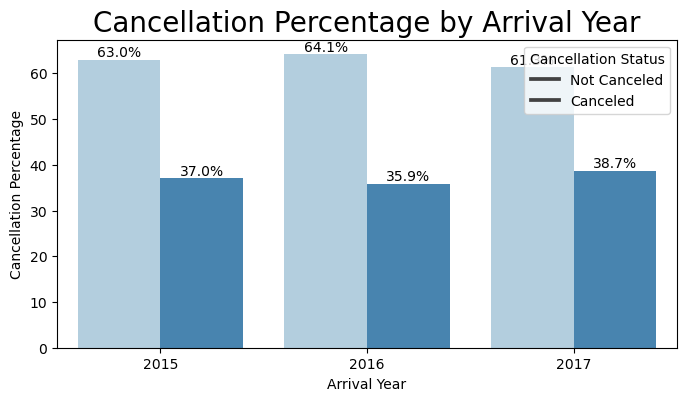

In [61]:
# arrival_date_year vs is_canceled
print(df['arrival_date_year'].value_counts())

# Calculate cancellation percentages for each arrival year
cancellation_percentages_year = df.groupby(['arrival_date_year', 'is_canceled']).size() / df.groupby('arrival_date_year').size() * 100
cancellation_percentages_year = cancellation_percentages_year.reset_index(name='Percentage')

# Plot the bar chart with percentages
plt.figure(figsize=(8, 4))
ax1 = sns.barplot(x='arrival_date_year', y='Percentage', hue='is_canceled', data=cancellation_percentages_year, palette='Blues')

# Annotate the bars with percentages
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.title('Cancellation Percentage by Arrival Year', size=20)
plt.xlabel('Arrival Year')
plt.ylabel('Cancellation Percentage')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

Percentage of cancellations was higher in 2015 and 2017 despite higher number of bookings in 2016.

#### arrival_date_month

In [11]:
# arrival_date_month vs is_canceled 
# first sort month column as function
def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

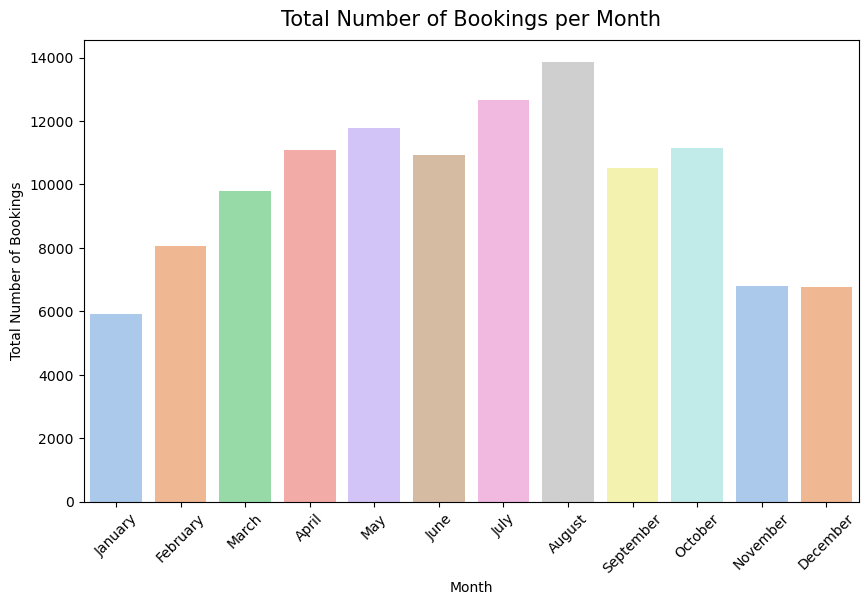

In [13]:
# Sort DataFrame by 'arrival_date_month'
sorted_df = sort_month(df, 'arrival_date_month')

# Data Visualization - Count plot for 'arrival_date_month'
plt.figure(figsize=(10, 6))
sns.countplot(data=sorted_df, x='arrival_date_month', palette='pastel')
plt.xlabel('Month')
plt.ylabel('Total Number of Bookings')
plt.title('Total Number of Bookings per Month', fontsize=15, pad=10)

# Set the x-axis labels as month names
month_names = sorted_df['arrival_date_month'].unique()
plt.xticks(ticks=range(len(month_names)), labels=month_names, rotation=45)

plt.show()

Highest Bookimg months July following by August.

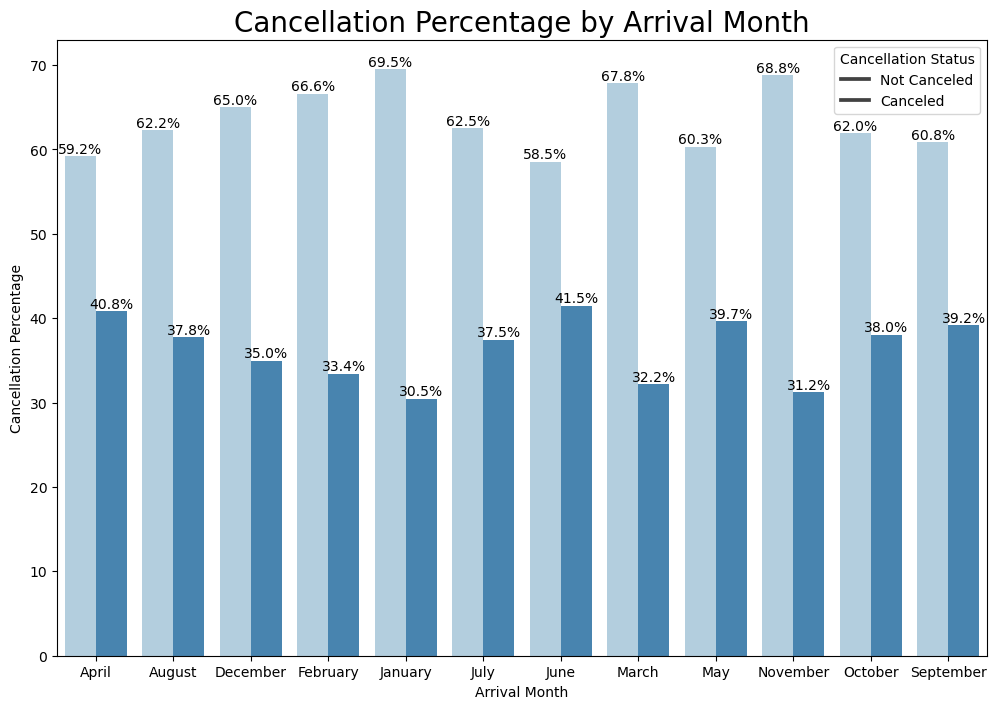

In [23]:
sorted_df = sort_month(df, 'arrival_date_month')

# Calculate cancellation percentages for each 'arrival_date_month'
cancellation_percentages = sorted_df.groupby(['arrival_date_month', 'is_canceled']).size() / sorted_df.groupby('arrival_date_month').size() * 100
cancellation_percentages = cancellation_percentages.reset_index(name='Percentage')

# Plot the bar chart with percentages
plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x='arrival_date_month', y='Percentage', hue='is_canceled', data=cancellation_percentages, palette='Blues')

# Annotate the bars with percentages
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.title('Cancellation Percentage by Arrival Month', size=20)
plt.xlabel('Arrival Month')
plt.ylabel('Cancellation Percentage')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

April and June had the largest cancellations overall.

#### night stays 

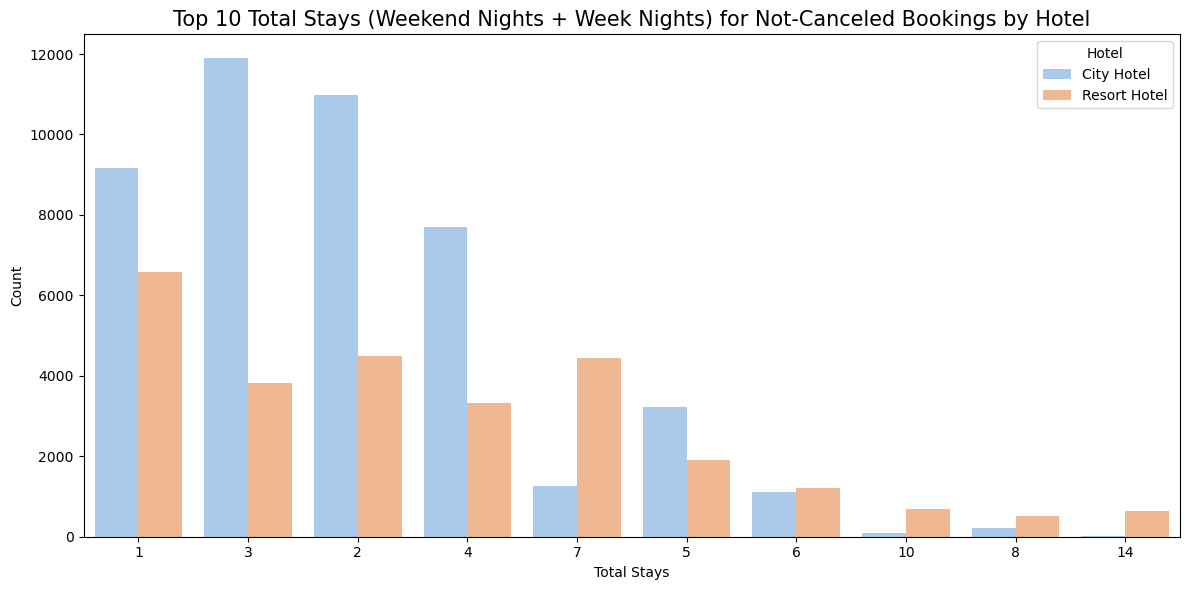

In [12]:
# Top 10 Nights Stayed 
# stay duration 
# Filter data for not-canceled bookings
not_canceled_df = df[df['is_canceled'] == 0]

not_canceled_df_filtered = not_canceled_df[(not_canceled_df['stays_in_week_nights'] > 0) | (not_canceled_df['stays_in_weekend_nights'] > 0)]

# Calculate the sum of 'stays_in_weekend_nights' and 'stays_in_week_nights'
total_stays = not_canceled_df_filtered['stays_in_weekend_nights'] + not_canceled_df_filtered['stays_in_week_nights']

# Calculate the top 10 total stays
top_10_stays = total_stays.value_counts().nlargest(10).sort_values(ascending=False)

# Data Visualization - Count plot for top 10 total stays with 'hotel' as hue
plt.figure(figsize=(12, 6))
sns.countplot(data=not_canceled_df,
              x=not_canceled_df['stays_in_weekend_nights'] + not_canceled_df['stays_in_week_nights'],
              hue='hotel', hue_order=['City Hotel', 'Resort Hotel'], palette='pastel', order=top_10_stays.index)
plt.title('Top 10 Total Stays (Weekend Nights + Week Nights) for Not-Canceled Bookings by Hotel', size=15)
plt.xlabel('Total Stays')
plt.ylabel('Count')
plt.legend(title='Hotel', loc='upper right')
plt.tight_layout()
plt.show()

In [10]:
top_10_stays

1     15749
3     15725
2     15480
4     11025
7      5686
5      5121
6      2322
10      783
8       720
14      659
dtype: int64

#### market_segment vs is_canceled

<Figure size 1000x600 with 0 Axes>

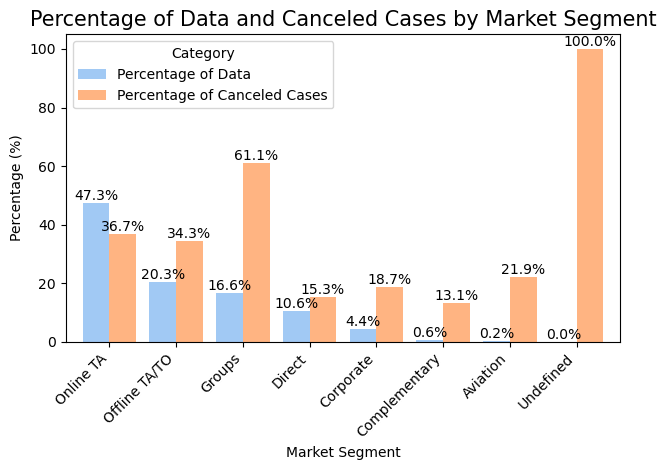

In [39]:
# Calculate percentage of data for each market segment
data_percentages = df['market_segment'].value_counts(normalize=True) * 100

# Calculate percentage of 'is_canceled' cases for each market segment
cancellation_percentages = df['is_canceled'].groupby(df['market_segment']).mean() * 100

# Merge the two Series into a single DataFrame
merged_data = pd.merge(data_percentages, cancellation_percentages, left_index=True, right_index=True)
merged_data.columns = ['Percentage of Data', 'Percentage of Canceled Cases']

# Data Visualization - Bar plot for merged data
plt.figure(figsize=(10, 6))
ax = merged_data.plot(kind='bar', width=0.8, color=sns.color_palette('pastel'))
plt.title('Percentage of Data and Canceled Cases by Market Segment', size=15)
plt.xlabel('Market Segment')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', labels=['Percentage of Data', 'Percentage of Canceled Cases'])

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Online TA is having the maximum booking.

#### distribution_channel vs is_canceled

<Figure size 1000x600 with 0 Axes>

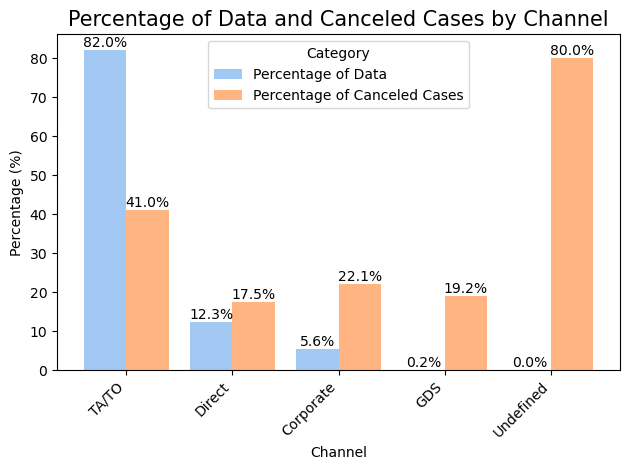

In [42]:
# Calculate percentage of data for Channel
data_percentages = df['distribution_channel'].value_counts(normalize=True) * 100

# Calculate percentage of 'is_canceled' cases for each market segment
cancellation_percentages = df['is_canceled'].groupby(df['distribution_channel']).mean() * 100

# Merge the two Series into a single DataFrame
merged_data = pd.merge(data_percentages, cancellation_percentages, left_index=True, right_index=True)
merged_data.columns = ['Percentage of Data', 'Percentage of Canceled Cases']

# Data Visualization - Bar plot for merged data
plt.figure(figsize=(10, 6))
ax = merged_data.plot(kind='bar', width=0.8, color=sns.color_palette('pastel'))
plt.title('Percentage of Data and Canceled Cases by Channel', size=15)
plt.xlabel('Channel')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', labels=['Percentage of Data', 'Percentage of Canceled Cases'])

# Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

TA/TO most booking use. 

#### customer_type vs is_canceled

Transient          75.059050
Transient-Party    21.043638
Contract            3.414021
Group               0.483290
Name: customer_type, dtype: float64


Text(0.5, 1.0, 'Average Number of cancellations in each category')

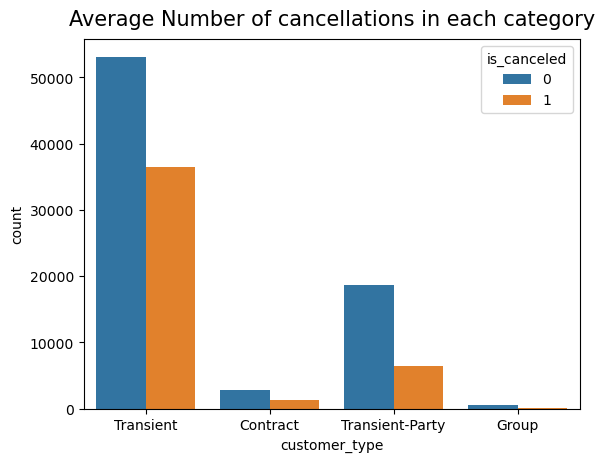

In [43]:
print(df['customer_type'].value_counts(normalize = True) * 100)
sns.countplot(data = df, x = 'customer_type', hue = 'is_canceled')
plt.title("Average Number of cancellations in each category", fontsize = 15, pad = 10)

75% bookings occur in Transient category of customers. It also sees the highest cancellation among all the categories.

#### lead_time vs is_canceled

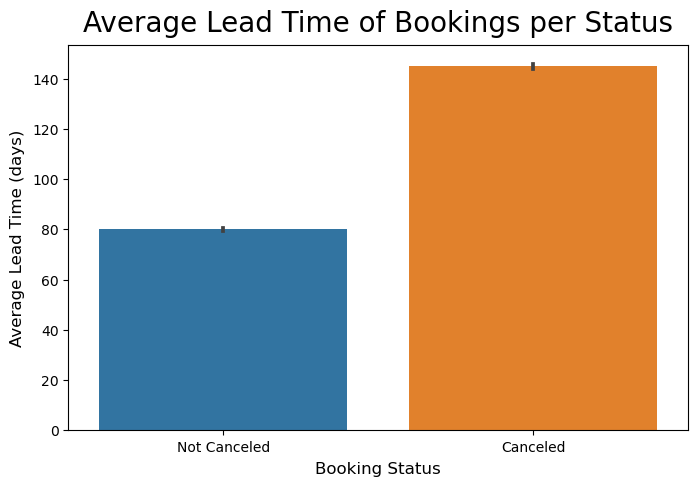

In [51]:
# lead_time vs is_canceled
plt.figure(figsize=(8,5)) 
plt.title("Average Lead Time of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['lead_time'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Lead Time (days)", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

Lower cancellations when the booking is made 60-70 days before the check-in date.

Longer the lead_time, higher is the cancellation.

#### total_of_special_requests vs  is_canceled

<Figure size 1000x600 with 0 Axes>

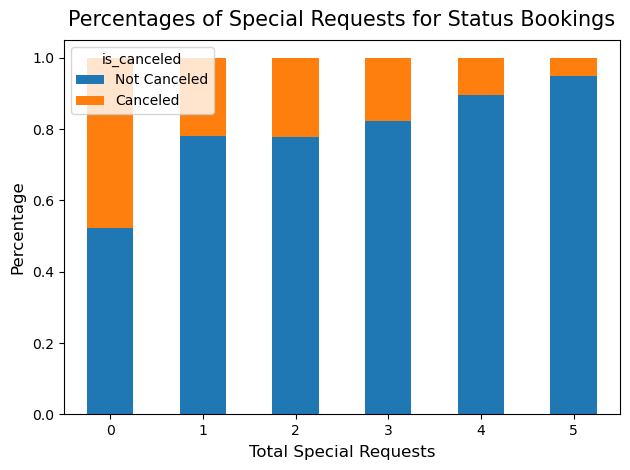

In [27]:
# Special Request vs Status
contingency_table = pd.crosstab(df['total_of_special_requests'], df['is_canceled'], normalize='index')

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.xlabel('Total Special Requests', fontsize=12, labelpad=5)
plt.ylabel('Percentage', fontsize=12, labelpad=5)
plt.title('Percentages of Special Requests for Status Bookings', fontsize=15, pad=10)
plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

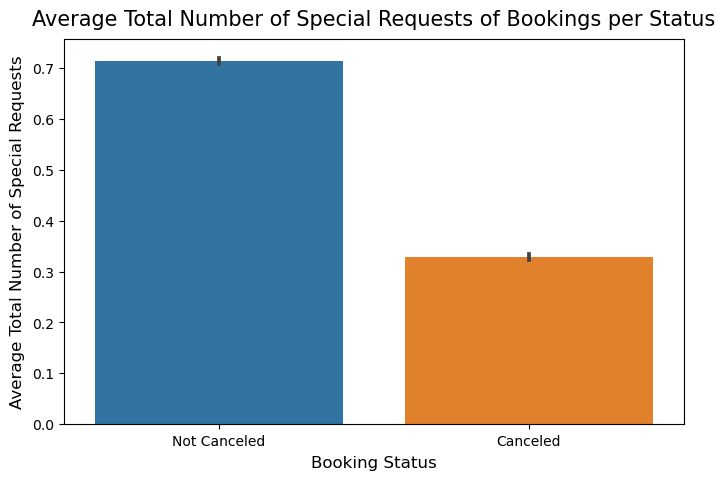

In [28]:
plt.figure(figsize=(8,5)) 
plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 15, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['total_of_special_requests'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

Customers who cancel their bookings make on fewer special requests. Negative Corelation (-23%)

### Country 

In [46]:
# From where the most guest are coming?
guest_city = df[df['is_canceled'] == 0]['country'].value_counts(normalize=True).reset_index()
guest_city.columns = ['Country', 'No of guests']
top_10_guest_cities = guest_city.nlargest(10, 'No of guests')
top_10_guest_cities

,Country,No of guests
0,PRT,0.281905
1,GBR,0.129453
2,FRA,0.113466
3,ESP,0.085504
4,DEU,0.081196
5,IRL,0.034022
6,ITA,0.032551
7,BEL,0.024992
8,NLD,0.022971
9,USA,0.021353


Most guests are from Portugal and other countries in Europe.

#### What are the Room prices overnights for each month?

In [75]:
# What are the Room prices overnights for each month?
data_resort = df[(df['hotel'] == 'Resort Hotel') & (df['is_canceled'] == 0)]
data_city = df[(df['hotel'] == 'City Hotel') & (df['is_canceled'] == 0)]
resort_hotel = data_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_hotel=data_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()
final_hotel  = resort_hotel . merge ( city_hotel , on = 'arrival_date_month' )

In [79]:
final_hotel.columns = [ 'month' , ' price_for_resort' , ' price_for_city_hotel' ]

In [84]:
def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [85]:
sort_month(final_hotel, 'month')

,month,price_for_resort,price_for_city_hotel
0,January,48.708919,82.160634
1,February,54.147478,86.183025
2,March,57.012487,90.170722
3,April,75.867816,111.856824
4,May,76.657558,120.445842
5,June,107.921869,117.702075
6,July,150.122528,115.563810
7,August,181.205892,118.412083
8,September,96.416860,112.598452
9,October,61.727505,101.745956


In [89]:
# Reshape the DataFrame to combine 'price_for_resort' and 'price_for_city_hotel'
melted_prices = pd.melt(final_hotel, id_vars='month', var_name='Hotel', value_name='Price')

# Create a line chart using Plotly Express
fig = px.line(melted_prices, x='month', y='Price', color='Hotel',
              title='Room price per night over the Months', template='plotly_dark')

# Set the figure size
fig.update_layout(width=1000, height=500)

# Show the plot
fig.show()

This plot clearly shows that prices in the Resort Hotel are much higher during the summer

In [ ]:
df.columns

#### Accommodation Type (Signle / Family/ couple ) 

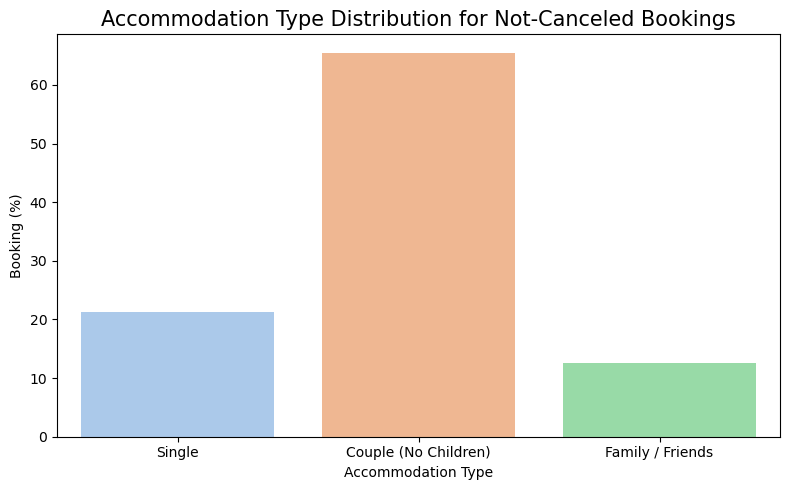

In [80]:
# Accommodation Type (Signle / Family/ couple )
# Filter data for not-canceled bookings
not_canceled_df = df[df['is_canceled'] == 0]

# Select single, couple, and family bookings
single = not_canceled_df[(not_canceled_df['adults'] == 1) & (not_canceled_df['children'] == 0) & (not_canceled_df['babies'] == 0)]
couple = not_canceled_df[(not_canceled_df['adults'] == 2) & (not_canceled_df['children'] == 0) & (not_canceled_df['babies'] == 0)]
family = not_canceled_df[not_canceled_df['adults'] + not_canceled_df['children'] + not_canceled_df['babies'] > 2]

# Make the list of category names and their total percentage
names = ['Single', 'Couple (No Children)', 'Family / Friends']
count = [single.shape[0], couple.shape[0], family.shape[0]]
count_percent = [x / not_canceled_df.shape[0] * 100 for x in count]

# Data Visualization - Bar plot for category percentages
plt.figure(figsize=(8, 5))
sns.barplot(x=names, y=count_percent, palette='pastel')
plt.xlabel('Accommodation Type')
plt.ylabel('Booking (%)')
plt.title('Accommodation Type Distribution for Not-Canceled Bookings', fontsize=15)
plt.tight_layout()
plt.show()

### Summary of EDA
* Almost 37% of bookings were canceled.
* More than 60% of the population booked the City hotel.
* More than double bookings were made in 2016, compared to the previous year. But the bookings decreased by almost 15% next year.
* Most bookings were made from July to August.
* Portugal, the UK, and France, Spain and Germany are the top countries from most guests come, more than 80% come from these 5 countries.
* Most people stay for one, two, or three.
-> For Resort hotel, the most popular stay duration is three, two, one, and four days respectively.
-> For City hotel, most popular stay duration is one, two, seven(week), and three respectively.
* Couple (or 2 adults) is the most popular accommodation type.
* Customers who cancel their bookings make on average fewer special requests. Negative correlation.
* Longer the lead_time, higher is the cancellation.
* 75% bookings occur in Transient category of customers. It also sees the highest cancellation among all the categories.
* Online TA is having the maximum booking.
* April and June had the largest cancellations overall.
* waiting period has no effect on cancellation of bookings.
* bookings that are non_refundable are canceled.
* no trend in it's impact on the cancellation of booking_changes.
* There are only 5% cancellations in such a case in case room type not assigned.
* Maximum customers have 0 previous cancellations. They are less likely to cancel the current booking.


## Feature engineering

In [81]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [94]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [48]:
df_subset = preprocess_data(df)

Drop useless columns:

One of the most important properties in data for prediction models is not to promote leakage of future information.

 In order to prevent this from happening, the timestamp of the target variable must occur after the input variables’ timestamp.
 
Thus, instead of directly extracting variables from the bookings database table, when available, 

the variables’ values were extracted from the bookings change log, with a timestamp relative to the day prior to arrival date (for all the bookings created before their arrival date).


In [9]:
df_subset.shape

(86639, 24)

In [10]:
df_subset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type', 'deposit_type',
       'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date'],
      dtype='object')

##### Encoding

In [11]:
print(df.shape)
df_subset.shape

(119390, 32)


(86639, 24)

In [147]:
categorical_feature = [feature for feature in df_subset.columns if df_subset[feature].dtype == 'object']
continuous_feature = [feature for feature in df_subset.columns if df_subset[feature].dtype != 'object']
df_cat = df_subset[categorical_feature]
df_num = df_subset[continuous_feature]

In [148]:
df_cat.columns

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'deposit_type',
       'customer_type', 'reservation_status_date'],
      dtype='object')

In [49]:
df_encoded, df_num = encode_categorical(df_subset)

In [50]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86639 entries, 2 to 119389
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     86639 non-null  int64  
 1   lead_time                       86639 non-null  int64  
 2   stays_in_weekend_nights         86639 non-null  int64  
 3   stays_in_week_nights            86639 non-null  int64  
 4   adults                          86639 non-null  int64  
 5   children                        86639 non-null  int64  
 6   babies                          86639 non-null  int64  
 7   is_repeated_guest               86639 non-null  int64  
 8   previous_cancellations          86639 non-null  int64  
 9   previous_bookings_not_canceled  86639 non-null  int64  
 10  agent                           86639 non-null  int64  
 11  days_in_waiting_list            86639 non-null  int64  
 12  adr                            

The general practice in machine learning is to perform scaling after splitting the dataset into training and testing sets.

 The reason for this is to avoid data leakage, which can occur when information from the test set influences the scaling process.

## Model Building

In [51]:
# Combining DataFrames
df_new =pd.concat([df_encoded,df_num],axis=1)
df_new.head(3)

,year,month,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,2015,7,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,7,0,1,1,0,0,0,0,0,0,0,75.0,0,0
3,2015,7,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,13,0,1,1,0,0,0,0,0,304,0,75.0,0,0
4,2015,7,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,14,0,2,2,0,0,0,0,0,240,0,98.0,0,1


### Train-test split

In [15]:
# Separate the target variable 'is_canceled' from the rest of the features
X = df_new.drop('is_canceled', axis=1)  # Features (all columns except 'is_canceled')
y = df_new['is_canceled']  # Target variable 'is_canceled'

# Perform the train-test split (80% training data, 20% testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scaling

In [16]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

### RandomForestClassifier

In [17]:
# Initialize the RandomForestClassifier
# n_estimators default = 100
rf_classifier = RandomForestClassifier(random_state=42)

In [18]:
# Train the model on the scaled training data
rf_classifier.fit(X_train_std, y_train)
# Predict on the testing data
rf_y_pred = rf_classifier.predict(X_test_std)

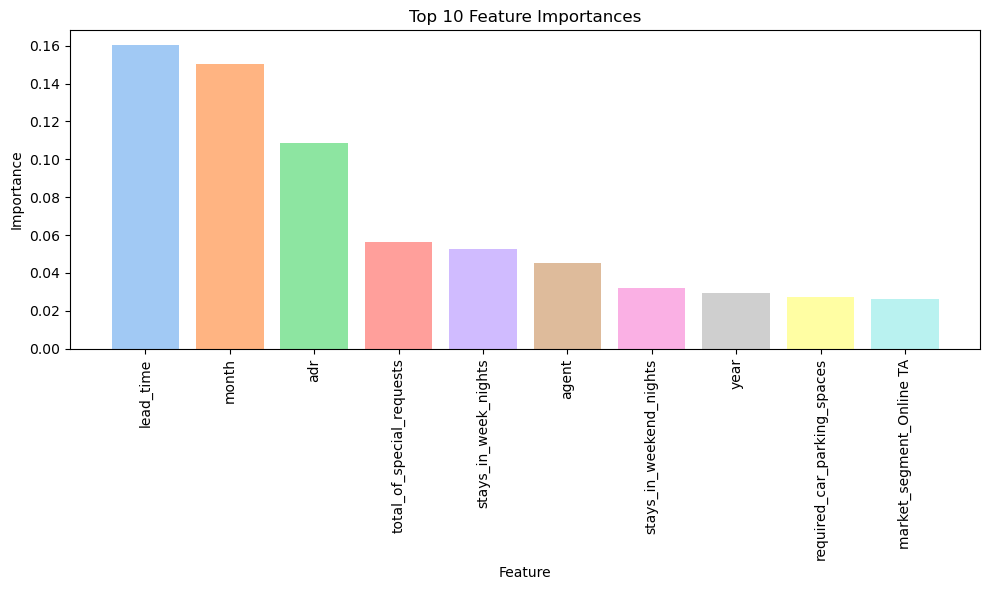

In [19]:
feature_importances = rf_classifier.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot the feature importances using a bar plot

# Select the top 10 important features
top_10_features = feature_importance_df.head(10)

# Define colors for the bars
colors = sns.color_palette('pastel', n_colors=len(top_10_features))

# Plot the top 10 feature importances using a bar plot with colors
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_features)), top_10_features['Importance'], color=colors)
plt.xticks(range(len(top_10_features)), top_10_features['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [20]:
# Evaluate the model's performance
rf_accuracy  = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
classification_rep = classification_report(y_test, rf_y_pred)
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Print the results
print("Random Forest Classifier Results:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"Precision: {rf_precision:.2f}")

print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Random Forest Classifier Results:
Accuracy: 0.90
Recall: 0.71
Precision: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     18839
           1       0.91      0.71      0.80      7153

    accuracy                           0.90     25992
   macro avg       0.90      0.84      0.87     25992
weighted avg       0.90      0.90      0.90     25992

Confusion Matrix:
[[18326   513]
 [ 2063  5090]]


### Logistic Regression

In [21]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_std, y_train)
logistic_y_pred  = logistic_model.predict(X_test_std)

In [22]:
logistic_model.classes_

array([0, 1], dtype=int64)

In [23]:
# Evaluate the model's performance
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_recall = recall_score(y_test, logistic_y_pred)
logistic_precision = precision_score(y_test, logistic_y_pred)

classification_rep = classification_report(y_test, logistic_y_pred)
conf_matrix = confusion_matrix(y_test, logistic_y_pred)

# Print the results
print("Logistic Regression Results:")
print(f"Accuracy: {logistic_accuracy:.2f}")
print(f"Recall: {logistic_recall:.2f}")
print(f"Precision: {logistic_precision:.2f}")

print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Logistic Regression Results:
Accuracy: 0.80
Recall: 0.44
Precision: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87     18839
           1       0.74      0.44      0.55      7153

    accuracy                           0.80     25992
   macro avg       0.78      0.69      0.71     25992
weighted avg       0.79      0.80      0.79     25992

Confusion Matrix:
[[17712  1127]
 [ 3978  3175]]


### KNN

In [24]:
# Initialize the KNeighborsClassifier with the desired number of neighbors (e.g., n_neighbors=5)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the model on the training data
knn_classifier.fit(X_train_std, y_train)
# Predict on the testing data
knn_y_pred = knn_classifier.predict(X_test_std)

In [25]:
# Evaluate the model's performance
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)

classification_rep = classification_report(y_test, knn_y_pred)
conf_matrix = confusion_matrix(y_test, knn_y_pred)

# Print the results
print("KNN Results:")
print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Recall: {knn_recall:.2f}")
print(f"Precision: {knn_precision:.2f}")

print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

KNN Results:
Accuracy: 0.82
Recall: 0.54
Precision: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18839
           1       0.73      0.54      0.62      7153

    accuracy                           0.82     25992
   macro avg       0.79      0.73      0.75     25992
weighted avg       0.81      0.82      0.81     25992

Confusion Matrix:
[[17407  1432]
 [ 3257  3896]]


### XGBClassifier

In [28]:
# Initialize the XGBClassifier 
xgb_classifier = XGBClassifier()
# Train the model on the training data
xgb_classifier.fit(X_train_std, y_train)
# Predict on the testing data
xgb_y_pred = xgb_classifier.predict(X_test_std)

In [29]:
# Evaluate the model's performance
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)

classification_rep = classification_report(y_test, xgb_y_pred)
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Print the results
print("XGB Results:")
print(f"Accuracy: {xgb_accuracy:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"Precision: {xgb_precision:.2f}")

print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

XGB Results:
Accuracy: 0.93
Recall: 0.75
Precision: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     18839
           1       0.97      0.75      0.85      7153

    accuracy                           0.93     25992
   macro avg       0.94      0.87      0.90     25992
weighted avg       0.93      0.93      0.92     25992

Confusion Matrix:
[[18686   153]
 [ 1772  5381]]


In [31]:
# Create a DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame({
    'Model': ['RandomForestClassifier', 'Logistic Regression', 'KNN', 'XGBClassifier'],
    'Accuracy': [rf_accuracy, logistic_accuracy, knn_accuracy, xgb_accuracy],
    'Recall': [rf_recall, logistic_recall, knn_recall, xgb_recall],
    'Precision': [rf_precision, logistic_precision, knn_precision, xgb_precision]
})

metrics_df

,Model,Accuracy,Recall,Precision
0,RandomForestClassifier,0.900893,0.711590,0.908442
1,Logistic Regression,0.803593,0.443870,0.738029
2,KNN,0.819598,0.544667,0.731231
3,XGBClassifier,0.925939,0.752272,0.972353


By comparing different machine learning models based on accuracy score it is found that XGBClassifier works best for this dataset.

Same thing in metrics Precision and Recall.

### Hyperparameter Tuning - Hyperparameter optimization

In [56]:
# Define the scoring function
def scoring_function(y_true, y_pred):
    return np.mean(np.abs(y_true, y_pred))

In [57]:
from sklearn.metrics import make_scorer
scorer = make_scorer(scoring_function, greater_is_better=False)

In [60]:
# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('model__learning_rate', 0.01, 1.0, log=True)
    n_estimators = trial.suggest_int('model__n_estimators', 50, 100)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler'])

    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    else:
        scaler = MaxAbsScaler()

    model = Pipeline(
        [
            ('scaler', scaler),
            ('model', XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators))
        ])

    # Calculate the cross-validated accuracy using the scoring function
    score = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_absolute_error").mean()

    print("Scores:", score)  # Add this line to print the scores

    return score


In [61]:
# Run the optimization process
study = optuna.create_study(direction='maximize')  # Use 'maximize' since we want to maximize accuracy
study.optimize(objective, n_trials=10)  # You can set the number of trials as needed


[I 2023-07-30 14:02:51,328] A new study created in memory with name: no-name-aa440647-b22e-44d8-b3da-f2264a8b0c3b
[I 2023-07-30 14:03:07,400] Trial 0 finished with value: -0.1639794590053017 and parameters: {'model__learning_rate': 0.8738852429466356, 'model__n_estimators': 64, 'scaler_type': 'MinMaxScaler'}. Best is trial 0 with value: -0.1639794590053017.


Scores: -0.1639794590053017


[I 2023-07-30 14:03:30,941] Trial 1 finished with value: -0.15448975133068216 and parameters: {'model__learning_rate': 0.3225934283939807, 'model__n_estimators': 66, 'scaler_type': 'MinMaxScaler'}. Best is trial 1 with value: -0.15448975133068216.


Scores: -0.15448975133068216


[I 2023-07-30 14:03:59,101] Trial 2 finished with value: -0.15108584484720697 and parameters: {'model__learning_rate': 0.4095407182306936, 'model__n_estimators': 82, 'scaler_type': 'MinMaxScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.15108584484720697


[I 2023-07-30 14:04:19,873] Trial 3 finished with value: -0.15794503981862945 and parameters: {'model__learning_rate': 0.27779847669154073, 'model__n_estimators': 57, 'scaler_type': 'StandardScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.15794503981862945


[I 2023-07-30 14:04:39,116] Trial 4 finished with value: -0.17711163828598628 and parameters: {'model__learning_rate': 0.169752075019033, 'model__n_estimators': 53, 'scaler_type': 'MinMaxScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.17711163828598628


[I 2023-07-30 14:05:00,675] Trial 5 finished with value: -0.33981426795635966 and parameters: {'model__learning_rate': 0.02116498583670761, 'model__n_estimators': 60, 'scaler_type': 'MinMaxScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.33981426795635966


[I 2023-07-30 14:05:20,666] Trial 6 finished with value: -0.1542960767567215 and parameters: {'model__learning_rate': 0.6404717721717409, 'model__n_estimators': 56, 'scaler_type': 'StandardScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.1542960767567215


[I 2023-07-30 14:05:40,809] Trial 7 finished with value: -0.2606828685747399 and parameters: {'model__learning_rate': 0.05231972832013486, 'model__n_estimators': 55, 'scaler_type': 'StandardScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.2606828685747399


[I 2023-07-30 14:06:09,481] Trial 8 finished with value: -0.36937415320761463 and parameters: {'model__learning_rate': 0.01134489658545666, 'model__n_estimators': 82, 'scaler_type': 'StandardScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.36937415320761463


[I 2023-07-30 14:06:32,130] Trial 9 finished with value: -0.3329823010033349 and parameters: {'model__learning_rate': 0.02164401819115782, 'model__n_estimators': 63, 'scaler_type': 'MinMaxScaler'}. Best is trial 2 with value: -0.15108584484720697.


Scores: -0.3329823010033349


In [64]:
study.trials_dataframe().sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_model__learning_rate,params_model__n_estimators,params_scaler_type,state
8,8,-0.369374,2023-07-30 14:05:40.810527,2023-07-30 14:06:09.481916,0 days 00:00:28.671389,0.011345,82,StandardScaler,COMPLETE
5,5,-0.339814,2023-07-30 14:04:39.117436,2023-07-30 14:05:00.674216,0 days 00:00:21.556780,0.021165,60,MinMaxScaler,COMPLETE
9,9,-0.332982,2023-07-30 14:06:09.482915,2023-07-30 14:06:32.129073,0 days 00:00:22.646158,0.021644,63,MinMaxScaler,COMPLETE
7,7,-0.260683,2023-07-30 14:05:20.668091,2023-07-30 14:05:40.808527,0 days 00:00:20.140436,0.052320,55,StandardScaler,COMPLETE
4,4,-0.177112,2023-07-30 14:04:19.874967,2023-07-30 14:04:39.116436,0 days 00:00:19.241469,0.169752,53,MinMaxScaler,COMPLETE
0,0,-0.163979,2023-07-30 14:02:51.330409,2023-07-30 14:03:07.400265,0 days 00:00:16.069856,0.873885,64,MinMaxScaler,COMPLETE
3,3,-0.157945,2023-07-30 14:03:59.102405,2023-07-30 14:04:19.872967,0 days 00:00:20.770562,0.277798,57,StandardScaler,COMPLETE
1,1,-0.154490,2023-07-30 14:03:07.401265,2023-07-30 14:03:30.940108,0 days 00:00:23.538843,0.322593,66,MinMaxScaler,COMPLETE
6,6,-0.154296,2023-07-30 14:05:00.676217,2023-07-30 14:05:20.666534,0 days 00:00:19.990317,0.640472,56,StandardScaler,COMPLETE
2,2,-0.151086,2023-07-30 14:03:30.942108,2023-07-30 14:03:59.100404,0 days 00:00:28.158296,0.409541,82,MinMaxScaler,COMPLETE


In [63]:
# Get the best hyperparameters
best_params = study.best_params
best_learning_rate = best_params['model__learning_rate']
best_n_estimators = best_params['model__n_estimators']
best_scaler = best_params["scaler_type"]

print("Best Hyperparameters:")
print("Learning Rate:", best_learning_rate)
print("Number of Estimators:", best_n_estimators)
print("Scaler Type:", best_scaler)

Best Hyperparameters:
Learning Rate: 0.4095407182306936
Number of Estimators: 82
Scaler Type: MinMaxScaler


#### accuracy_scorer

In [71]:
def accuracy_scorer(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [73]:
scorer_01 = make_scorer(accuracy_scorer, greater_is_better=True)

In [74]:
def objective_01(trial):
    learning_rate = trial.suggest_float('model__learning_rate', 0.01, 1.0, log=True)
    n_estimators = trial.suggest_int('model__n_estimators', 50, 100)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler'])

    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    else:
        scaler = MaxAbsScaler()

    model = Pipeline(
        [
            ('scaler', scaler),
            ('model', XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators))
        ])

    # Calculate the cross-validated accuracy using the scoring function
    accuracy = cross_val_score(model, X_train, y_train, cv=10, scoring = scorer_01).mean()

    print("Accuracy:", accuracy)

    return accuracy


In [77]:
study_01 = optuna.create_study(direction='maximize')  # Use 'maximize' since we want to maximize accuracy
study_01.optimize(objective_01, n_trials=10)  # You can set the number of trials as needed

[I 2023-07-30 14:47:17,007] A new study created in memory with name: no-name-aaa644c2-d6b6-4227-83c8-3e0aa3a7c5d6
[I 2023-07-30 14:47:41,033] Trial 0 finished with value: 0.9256682063485503 and parameters: {'model__learning_rate': 0.49975970555554244, 'model__n_estimators': 87, 'scaler_type': 'MinMaxScaler'}. Best is trial 0 with value: 0.9256682063485503.
[I 2023-07-30 14:48:10,958] Trial 1 finished with value: 0.92311239061443 and parameters: {'model__learning_rate': 0.14804589860556694, 'model__n_estimators': 87, 'scaler_type': 'StandardScaler'}. Best is trial 0 with value: 0.9256682063485503.
[I 2023-07-30 14:48:32,840] Trial 2 finished with value: 0.8637030699741366 and parameters: {'model__learning_rate': 0.06968360388242928, 'model__n_estimators': 62, 'scaler_type': 'MinMaxScaler'}. Best is trial 0 with value: 0.9256682063485503.
[I 2023-07-30 14:49:05,953] Trial 3 finished with value: 0.9235410172776453 and parameters: {'model__learning_rate': 0.1439244564762051, 'model__n_esti

In [78]:
best_params = study_01.best_params
best_learning_rate = best_params['model__learning_rate']
best_n_estimators = best_params['model__n_estimators']
best_scaler = best_params["scaler_type"]
best_accuracy = study_01.best_value

print("Best Hyperparameters:")
print("Learning Rate:", best_learning_rate)
print("Number of Estimators:", best_n_estimators)
print("Scaler Type:", best_scaler)
print("Best Accuracy:", best_accuracy)

Best Hyperparameters:
Learning Rate: 0.49975970555554244
Number of Estimators: 87
Scaler Type: MinMaxScaler
Best Accuracy: 0.9256682063485503


In [79]:
study_01.trials_dataframe().sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_model__learning_rate,params_model__n_estimators,params_scaler_type,state
2,2,0.863703,2023-07-30 14:48:10.959658,2023-07-30 14:48:32.840823,0 days 00:00:21.881165,0.069684,62,MinMaxScaler,COMPLETE
6,6,0.894240,2023-07-30 14:49:52.631403,2023-07-30 14:50:21.216913,0 days 00:00:28.585510,0.078739,82,StandardScaler,COMPLETE
1,1,0.923112,2023-07-30 14:47:41.034911,2023-07-30 14:48:10.958658,0 days 00:00:29.923747,0.148046,87,StandardScaler,COMPLETE
3,3,0.923541,2023-07-30 14:48:32.841823,2023-07-30 14:49:05.953058,0 days 00:00:33.111235,0.143924,96,StandardScaler,COMPLETE
7,7,0.923574,2023-07-30 14:50:21.218912,2023-07-30 14:50:50.540290,0 days 00:00:29.321378,0.155229,86,MinMaxScaler,COMPLETE
9,9,0.924761,2023-07-30 14:51:16.962886,2023-07-30 14:51:54.704570,0 days 00:00:37.741684,0.231860,70,MaxAbsScaler,COMPLETE
4,4,0.925025,2023-07-30 14:49:05.954058,2023-07-30 14:49:26.884803,0 days 00:00:20.930745,0.335357,60,MinMaxScaler,COMPLETE
5,5,0.925075,2023-07-30 14:49:26.885802,2023-07-30 14:49:52.629800,0 days 00:00:25.743998,0.208493,74,StandardScaler,COMPLETE
8,8,0.925421,2023-07-30 14:50:50.541290,2023-07-30 14:51:16.961442,0 days 00:00:26.420152,0.545204,71,StandardScaler,COMPLETE
0,0,0.925668,2023-07-30 14:47:17.008962,2023-07-30 14:47:41.033911,0 days 00:00:24.024949,0.499760,87,MinMaxScaler,COMPLETE
